In [1]:
import numpy as np
import verde as vd
import harmonica as hm
import matplotlib.pyplot as plt
import xarray as xr
import pyvista

In [2]:
pyvista.start_xvfb()

In [3]:
region = [0, 20e3, 0, 30e3, -5e3, 0]

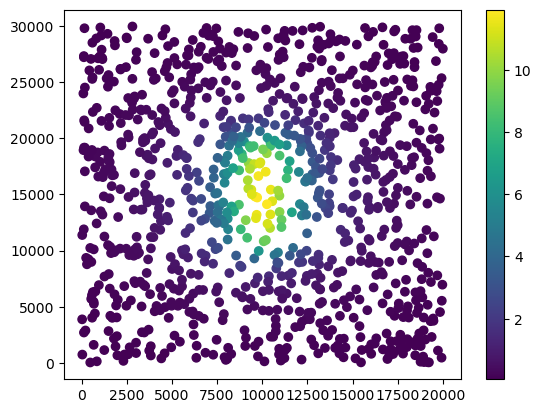

In [4]:
coordinates = vd.scatter_points(region[:4], size=1000, extra_coords=10)
model = [9e3, 11e3, 10e3, 20e3, -3e3, -1e3]
density = 500
data = hm.prism_gravity(coordinates, model, density, field="g_z")

plt.scatter(*coordinates[:2], c=data)
plt.colorbar()

In [5]:
def build_mesh(region, spacing):
    easting, northing = vd.grid_coordinates(region[:4], spacing=spacing, adjust="region", pixel_register=True)
    _, vertical = vd.grid_coordinates(region[2:], spacing=spacing, adjust="region", pixel_register=True)
    coordinates = easting[0, :], northing[:, 0], vertical[:, 0]
    shape = tuple(c.size for c in reversed(coordinates))
    dims = ("vertical", "northing", "easting")
    mesh = xr.Dataset(
        {"density": (dims, np.zeros(shape))}, 
        dict((name, c) for name, c in zip(dims, reversed(coordinates))),
    )
    mesh.attrs["cell_size"] = tuple(mesh[dim][1].values - mesh[dim][0].values for dim in dims)
    mesh.attrs["region"] = region
    return mesh


def get_prism(index, mesh):
    center = [mesh[dim].values[i] for i, dim in zip(index, mesh.dims)]
    bounds = []
    for c, size in reversed(list(zip(center, mesh.attrs["cell_size"]))):
        bounds.extend([c - size/2, c + size/2])
    return bounds


def mesh_to_prisms(mesh, include_zero=True):
    shape = [mesh[dim].size for dim in mesh.dims]
    prisms = [
        get_prism((i, j, k), mesh)
        for i in range(shape[0])
        for j in range(shape[1])
        for k in range(shape[2])
        if include_zero or mesh.density[i, j, k] != 0
    ]
    return prisms


def shape_of_anomaly(observed, predicted, observed_norm):
    alpha = np.sum(observed * predicted) / observed_norm ** 2
    result = np.linalg.norm(alpha * observed - predicted)
    return result


def rms(observed, predicted, observed_norm):
    result = np.linalg.norm(observed - predicted) / observed_norm
    return result


def distance(seed, index):
    return np.linalg.norm(np.asarray(seed) - np.asarray(index))


def get_seed_index(position, mesh):
    return tuple(np.argmin(np.abs(mesh[dim].values - coord)) for dim, coord in zip(mesh.dims, reversed(position)))


def get_neighbors(index, mesh):
    neighbors = []
    shape = [mesh[dim].size for dim in mesh.dims]
    for dim in range(len(index)):
        if index[dim] >= 1:
            neighbor = list(index)
            neighbor[dim] -= 1
            neighbors.append(tuple(neighbor))
        if index[dim] < shape[dim] - 1:
            neighbor = list(index)
            neighbor[dim] += 1
            neighbors.append(tuple(neighbor))
    return neighbors        

In [9]:
mesh = build_mesh(region, spacing=0.5e3)
regularization = 1e-2
threshold = 1e-3

seed_position = (10e3, 15e3, -1.5e3)
seed_density = density
seed = get_seed_index(seed_position, mesh)
print("seed:", seed)

mesh.density[seed] = seed_density

predicted = np.zeros_like(data)
predicted += hm.prism_gravity(coordinates, get_prism(seed, mesh), mesh.density[seed], field="g_z", disable_checks=True)

observed_norm = np.linalg.norm(data)

jacobian = {}

neighborhood = get_neighbors(seed, mesh)
neighbor_density = {n: seed_density for n in neighborhood}
solution = [seed]

misfit = rms(data, predicted, observed_norm)
regul = 0

for i in range(mesh.density.size):
    best_goal = None
    best = None

    for neighbor in neighborhood:
        if neighbor not in jacobian:
            jacobian[neighbor] = hm.prism_gravity(coordinates, get_prism(neighbor, mesh), density=1, field="g_z", disable_checks=True)
        predicted_trial = predicted + neighbor_density[neighbor] * jacobian[neighbor]
        misfit_trial = rms(data, predicted_trial, observed_norm)
        if misfit_trial < misfit and (misfit - misfit_trial) / misfit >= threshold:
            goal = (
                shape_of_anomaly(data, predicted_trial, observed_norm)
                + regularization * (regul + distance(seed, neighbor))
            )
            if best_goal is None or goal < best_goal:
                best = neighbor
                best_goal = goal
    if best is None:
        break
    predicted += neighbor_density[best] * jacobian[best]
    misfit = rms(data, predicted, observed_norm)
    regul += distance(seed, neighbor)
    mesh.density[best] = neighbor_density[best]
    solution.append(best)
    neighborhood.remove(best)
    neighbor_density.pop(best)
    jacobian.pop(best)
    new_neighbors = [index for index in get_neighbors(best, mesh) if index not in solution and index not in neighborhood]
    neighborhood.extend(new_neighbors)
    neighbor_density.update({index: seed_density for index in new_neighbors})
mesh

seed: (6, 29, 19)


<xarray.Dataset>
Dimensions:   (vertical: 10, northing: 60, easting: 40)
Coordinates:
  * vertical  (vertical) float64 -4.75e+03 -4.25e+03 -3.75e+03 ... -750.0 -250.0
  * northing  (northing) float64 250.0 750.0 1.25e+03 ... 2.925e+04 2.975e+04
  * easting   (easting) float64 250.0 750.0 1.25e+03 ... 1.925e+04 1.975e+04
Data variables:
    density   (vertical, northing, easting) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    cell_size:  (500.0, 500.0, 500.0)
    region:     [0, 20000.0, 0, 30000.0, -5000.0, 0]

In [10]:
mesh_density = mesh.density.values.ravel()
prisms_vtk = hm.visualization.prism_to_pyvista(
    mesh_to_prisms(mesh, include_zero=False),
    {"density": mesh_density[mesh_density != 0]}
)
pv = pyvista.Plotter()
pv.add_mesh(prisms_vtk, scalars="density", show_edges=True, clim=[0, density])
pv.add_mesh(hm.visualization.prism_to_pyvista(model), style="wireframe")
pv.show(jupyter_backend='panel')

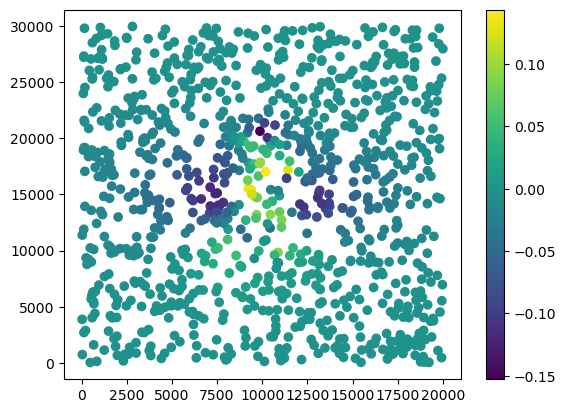

In [11]:
plt.scatter(*coordinates[:2], c=data - predicted)
plt.colorbar()